#### Домашнее задание по теме «Ансамблирование»

Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет 

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)

Построить случайный лес, вывести важность признаков.
Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную.
В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# увеличим размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [2]:
train = pd.read_csv(r'C:\Users\Urmas\Desktop\Digital\НЕТОЛОГИЯ. ПРОФЕССИЯ DATA SCIENTIST\Машинное обучение\Лекции. Презентации\Ансамблирование моделей\train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

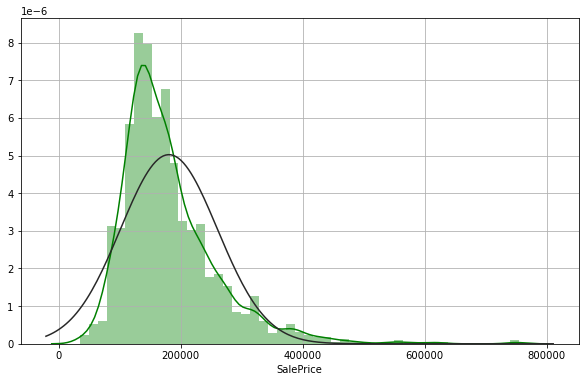

In [4]:
# Проверим нормальное распределение целевой переменной
from scipy.stats import norm

sns.distplot(train['SalePrice'], fit=norm, kde=True, color='g')
plt.grid()

# имеются большие выбросы

In [5]:
#train.isnull().sum()
nun = {}
for col in train.columns:
    miss = round(train[col].isnull().mean()*100,1)
    if miss > 0:
        nun[col] = miss

high_nun = [i for i, j in nun.items() if j > 80]
print(high_nun) 
print()

list_nun = list(nun.items())
list_nun.sort(key=lambda i: i[1],reverse=True)
small_nun = []
for i in list_nun:
    print(f'{i[0]}: {i[1]}%')
    if i[1]<10:
          small_nun.append(i[0])  # признаки с пропусками менее 10 %

# удалим колонки с большими пропусками (>80%)
train.drop(high_nun, axis=1, inplace=True)

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

PoolQC: 99.5%
MiscFeature: 96.3%
Alley: 93.8%
Fence: 80.8%
FireplaceQu: 47.3%
LotFrontage: 17.7%
GarageType: 5.5%
GarageYrBlt: 5.5%
GarageFinish: 5.5%
GarageQual: 5.5%
GarageCond: 5.5%
BsmtExposure: 2.6%
BsmtFinType2: 2.6%
BsmtQual: 2.5%
BsmtCond: 2.5%
BsmtFinType1: 2.5%
MasVnrType: 0.5%
MasVnrArea: 0.5%
Electrical: 0.1%


In [6]:
# удалим "битые" объекты в колонках с пропусками менее 10 % (количество данных позволяет)
for i in small_nun:
    train.drop(train.loc[pd.isnull(train[i]), :].index, axis=0, inplace=True)

In [7]:
# какие пропуски остались
mis = {}
for col in train.columns:
    miss = train[col].isnull().mean()
    if miss>0:
        mis[col] = miss
        print(f'{col} - {miss:.1%} - {train[col].dtypes}')

LotFrontage - 18.2% - float64
FireplaceQu - 44.2% - object


In [8]:
train.FireplaceQu.unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

FireplaceQu - категориальный признак качества камина. В значениях имеются нулевые данные (возможно, что нет камина). Проверим, есть ли камин в пропусках.

In [9]:
# в пропущенных данных камина нет (как и предполагали)
train.loc[pd.isnull(train['FireplaceQu']), 'Fireplaces'].value_counts()

0    591
Name: Fireplaces, dtype: int64

In [10]:
# нет камина и в нулевых значениях
train.loc[train['FireplaceQu']==0, 'Fireplaces'].value_counts()

Series([], Name: Fireplaces, dtype: int64)

In [11]:
# тогда пропуски в FireplaceQu заполним 0
train.FireplaceQu.fillna(0, inplace=True)

In [12]:
# проверяем, что пропусков в FireplaceQu не осталось
train.FireplaceQu.isnull().sum()

0

LotFrontage : Линейные ноги улицы, соединенной с земельным участком   - количественный признак с пропусками

предполагаю, что есть связь с признаком LotArea : Размер лота в квадратных футах
    
Применим линейную регрессию для восстановления пропусков

In [13]:
m = LinearRegression().fit(pd.DataFrame(train[~train['LotFrontage'].isnull()].LotArea),
                           train[~train['LotFrontage'].isnull()].LotFrontage)
train.loc[pd.isnull(train['LotFrontage']), 'LotFrontage'] = m.predict(np.array(train[train['LotFrontage'].isnull()].LotArea).reshape(-1,1))

In [14]:
# проверим заполнение пропусков
train['LotFrontage'].isnull().sum()

0

In [15]:
train.isnull().sum().value_counts()

0    77
dtype: int64

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1338 non-null   int64  
 1   MSSubClass     1338 non-null   int64  
 2   MSZoning       1338 non-null   object 
 3   LotFrontage    1338 non-null   float64
 4   LotArea        1338 non-null   int64  
 5   Street         1338 non-null   object 
 6   LotShape       1338 non-null   object 
 7   LandContour    1338 non-null   object 
 8   Utilities      1338 non-null   object 
 9   LotConfig      1338 non-null   object 
 10  LandSlope      1338 non-null   object 
 11  Neighborhood   1338 non-null   object 
 12  Condition1     1338 non-null   object 
 13  Condition2     1338 non-null   object 
 14  BldgType       1338 non-null   object 
 15  HouseStyle     1338 non-null   object 
 16  OverallQual    1338 non-null   int64  
 17  OverallCond    1338 non-null   int64  
 18  YearBuil

In [17]:
# Находим категориальные признаки
categor = list(train.dtypes[train.dtypes == object].index)
len(categor)

39

In [18]:
# оставим категориальные колонки со значениями не более 30
categor = [cat for cat in categor if train[cat].nunique() < 30]
len(categor)

39

In [19]:
# переведем категориальные признаки в числовые
train = pd.get_dummies(train, columns=categor, prefix_sep='_')
train

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,0,0,1,0,0,0,0,1,0
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,0,0,0,1,0,0,0,0,1,0
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,0,0,1,0,0,0,0,1,0
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,0,0,0,1,0,0,0,0,1,0


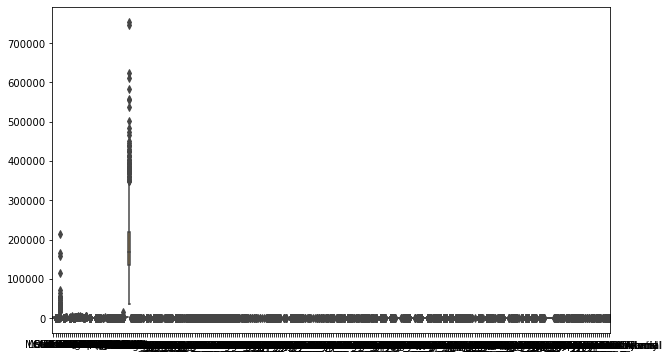

In [20]:
# посмотрим на выбросы
# построим boxplot

sns.boxplot(data=train)

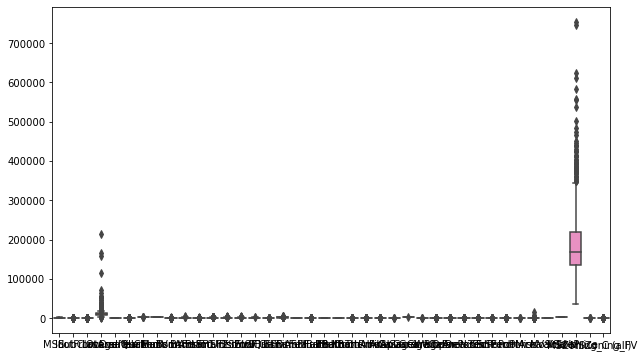

In [21]:
sns.boxplot(data=train.iloc[:,np.arange(40)])

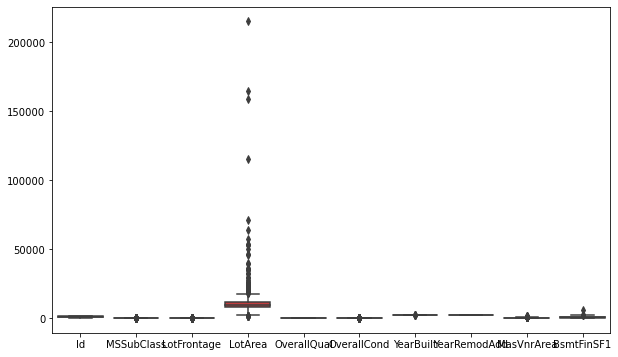

In [22]:
sns.boxplot(data=train.iloc[:,np.arange(10)])

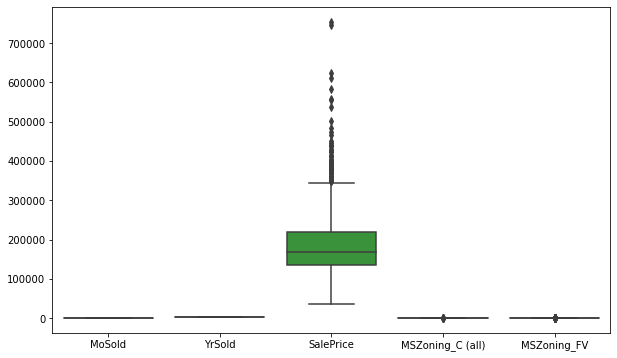

In [23]:
sns.boxplot(data=train.iloc[:,np.arange(35,40)])

In [24]:
# Имеем LotArea и целевую переменную SalePrice с большими выбросами
# LotArea и LotFrontage взаимосвязаны, но в последнем нет таких выбросов
# удалим выбросы LotArea, скорее всего, это ошибочно
train.LotArea.describe()

count      1338.000000
mean      10706.294469
std       10336.621126
min        1300.000000
25%        7744.000000
50%        9600.000000
75%       11760.750000
max      215245.000000
Name: LotArea, dtype: float64

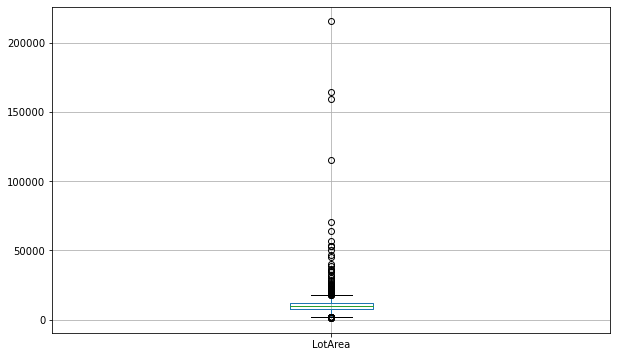

In [25]:
train.boxplot(column=['LotArea'])

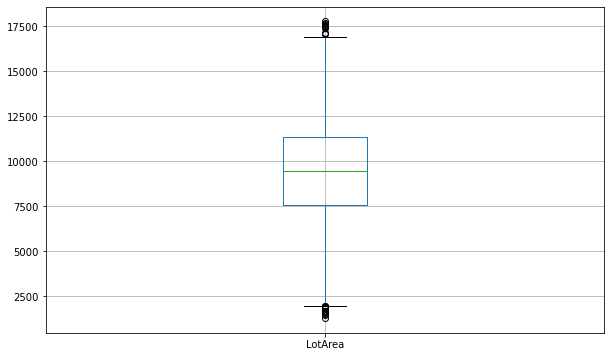

In [26]:
Q1 = train['LotArea'].quantile(0.25)
Q3 = train['LotArea'].quantile(0.75)
IQR = Q3 - Q1
# train = train.query('@Q1 - 1.5*@IQR < LotArea < @Q3 + 1.5*@IQR')
train = train.query('LotArea < @Q3 + 1.5*@IQR')
train.boxplot(column='LotArea')

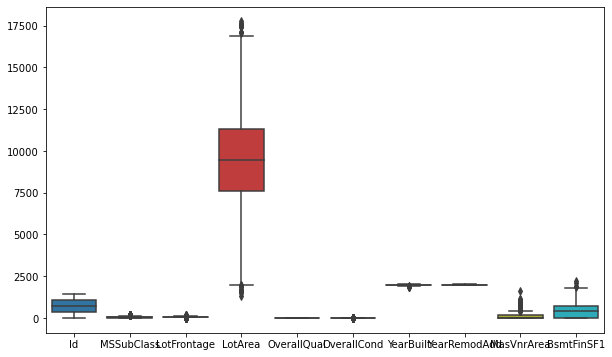

In [27]:
# проверим
sns.boxplot(data=train.iloc[:,np.arange(10)])

In [28]:
X = train.drop(['SalePrice'], axis=1)
y = train['SalePrice']

# для деревьев не страшны выбросы, пропуски, разный масштаб - подготавливать данные нет необходимости

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

clf_rf = RandomForestRegressor(random_state=1)

grid_params = {
        'criterion': ['mse', 'mae'],     # функция измерения качества разделения
        'max_depth': np.arange(5,16),        # максимальная глубина дерева
        'n_estimators': [10],             # количество моделей (деревьев)
        'min_samples_leaf': np.arange(10,21), # мин число объектов в листе
        'max_features': [0.5, None, 'auto', 'sqrt', 'log2']             # число признаков случайного подпространства
}

grid = GridSearchCV(clf_rf, param_grid=grid_params, cv=10, n_jobs=-1)
# grid - исчерпывающий поиск по заданным значениям параметров
# n_jobs - количество заданий для параллельного выполнения
# cv - количество фолдов
grid.fit(X_train, y_train) 

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'max_features': [0.5, None, 'auto', 'sqrt', 'log2'],
                         'min_samples_leaf': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                         'n_estimators': [10]})

In [31]:
print(grid.score(X_test, y_test))
print(grid.best_score_)

0.8809287994191959
0.8393935682080345


In [32]:
# лучшая модель (дерево)
estimator = grid.best_estimator_
estimator

RandomForestRegressor(max_depth=10, max_features=0.5, min_samples_leaf=10,
                      n_estimators=10, random_state=1)

In [33]:
# лучшие параметры
grid.best_params_

{'criterion': 'mse',
 'max_depth': 10,
 'max_features': 0.5,
 'min_samples_leaf': 10,
 'n_estimators': 10}

''

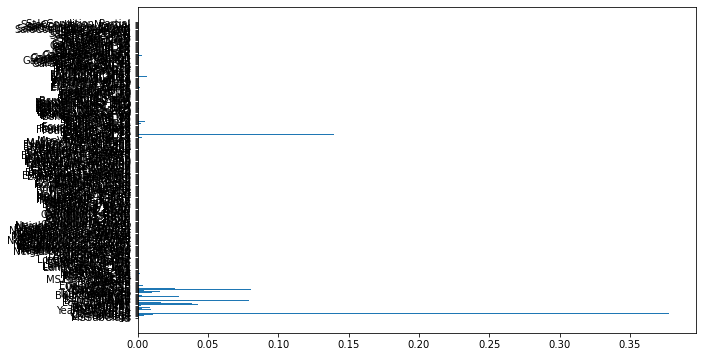

In [34]:
# важность признаков (визуально)
fich = grid.best_estimator_.feature_importances_
plt.barh(np.arange(len(fich)), fich)
plt.yticks(np.arange(len(X.columns)), X.columns)
''

In [35]:
# важность признаков
imp = pd.Series(estimator.feature_importances_)
imp.sort_values(ascending=False)

4      0.377922
168    0.139335
26     0.080442
16     0.079291
6      0.054453
         ...   
115    0.000000
116    0.000000
117    0.000000
118    0.000000
271    0.000000
Length: 272, dtype: float64

##### Композиции моделей разных типов

##### Стекинг

In [36]:
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [37]:
# стандартизируем данные для линейной регрессии
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
classifier = StackingRegressor(
    [
        ('lr', LinearRegression()),
        ('knn', KNeighborsRegressor(n_neighbors=10)),
        ('cart', DecisionTreeRegressor(max_depth=10, max_features = 0.5)),
        ('svm', SVR()),
        ('rf', RandomForestRegressor(n_estimators=10, max_depth=10, max_features = 0.5))
    ],
LinearRegression())

In [39]:
classifier.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('knn', KNeighborsRegressor(n_neighbors=10)),
                              ('cart',
                               DecisionTreeRegressor(max_depth=10,
                                                     max_features=0.5)),
                              ('svm', SVR()),
                              ('rf',
                               RandomForestRegressor(max_depth=10,
                                                     max_features=0.5,
                                                     n_estimators=10))],
                  final_estimator=LinearRegression())

In [40]:
proba = {}
named_estimator = ['lr', 'knn', 'cart', 'svm', 'rf']
for name in named_estimator:
    y_pred_named_estimator = classifier.named_estimators_[name].predict(X_test)
    proba[name] = y_pred_named_estimator

In [41]:
y_pred_proba = classifier.predict(X_test)

In [42]:
classifier.score(X_test, y_test)

0.896479263499222

##### Посмотрим на коэффициенты объединяющей линейной модели

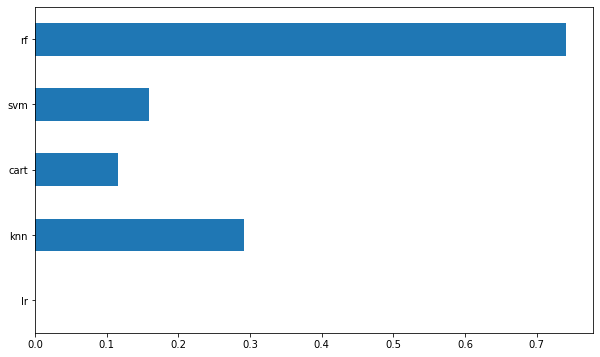

In [43]:
pd.Series(classifier.final_estimator_.coef_.flatten(), index=classifier.named_estimators_.keys()).plot(kind='barh')